# 05 — Customer Lifetime Value & Next Best Action

## From Predictions to Decisions

The previous notebooks answered two questions: *who will churn?* and *who will buy?*
This notebook answers the question that actually matters: **what should PlayStation
*do* about each player?**

This is the bridge between data science and business impact. A churn score sitting in a
database creates zero value. A churn score that triggers the right intervention, for the
right player, at the right time — that's where the ROI lives.

### What This Notebook Builds

1. **CLV Estimation** — How much is each player worth over the next 12 months? This determines
   how much we should be willing to spend to retain or grow them.

2. **Next Best Action Framework** — A decision engine that combines churn risk, purchase
   propensity, and CLV into a specific, actionable recommendation for each player.

3. **Business Impact Simulation** — If PlayStation deployed this framework, what would the
   expected revenue impact be?

### The Core Principle: Not All Players Deserve the Same Investment

A player with $500 CLV who's about to churn deserves a different response than a $5 CLV
player in the same risk tier. Similarly, a high-propensity player who's also at churn risk
needs retention *before* they get an upsell offer. The NBA framework encodes these priorities.

## Setup

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 100

DATA_DIR = Path("data")

# Load all inputs
player360 = pd.read_csv(DATA_DIR / "player360.csv")
churn_scores = pd.read_csv(DATA_DIR / "churn_scores.csv")
propensity_scores = pd.read_csv(DATA_DIR / "propensity_scores.csv")
subs = pd.read_csv(DATA_DIR / "subscriptions.csv")
purchases = pd.read_csv(DATA_DIR / "purchases.csv", parse_dates=["purchase_date"])
archetype_key = pd.read_csv(DATA_DIR / "_archetype_key.csv")

print(f"Player 360:        {len(player360):,} players")
print(f"Churn scores:      {len(churn_scores):,} scored (paid subs)")
print(f"Propensity scores: {len(propensity_scores):,} scored (all players)")

Player 360:        5,000 players
Churn scores:      3,643 scored (paid subs)
Propensity scores: 5,000 scored (all players)


---
# Part 1: Customer Lifetime Value Estimation

### Approach: Historical + Forward-Looking CLV

We use a practical CLV framework with two components:

**Historical CLV** — What has this player already spent? This is directly observable from
purchase data and represents the player's demonstrated value.

**Predicted 12-Month Forward CLV** — What will they likely spend in the next year?
This combines:
- **Subscription revenue**: tier price x 12 x (1 - churn probability)
- **Purchase revenue**: recent spend velocity projected forward, adjusted for churn risk

This is a simplified but production-realistic approach. In a real setting, you'd use
probabilistic models (BG/NBD + Gamma-Gamma for non-contractual, or survival models
for subscription), but the logic is the same: **future value = expected revenue x
probability of being active**.

> **Why not BG/NBD?** The BG/NBD model is designed for non-contractual settings (e.g.,
> retail purchases with no subscription). PlayStation's revenue is a mix of contractual
> (PS Plus subscription) and non-contractual (game/DLC purchases). Our hybrid approach
> handles both components. With real data and more time, a proper probabilistic CLV model
> would be the next step.

In [7]:
# ── Subscription Revenue Component ──

# Annual tier pricing (approximate real-world PS Plus pricing)
TIER_ANNUAL_PRICE = {
    "Free": 0,
    "Essential": 59.99,
    "Extra": 134.99,
    "Premium": 159.99,
}

# Build CLV table starting from player360
clv = player360[["player_id"]].copy()

# Add subscription info
clv = clv.merge(subs[["player_id", "tier", "is_active"]], on="player_id", how="left")

# Add churn probability (Free tier gets 0 — they can't churn from a paid sub)
clv = clv.merge(churn_scores[["player_id", "churn_probability"]], on="player_id", how="left")
clv["churn_probability"] = clv["churn_probability"].fillna(0.0)

# Subscription CLV: annual price * probability of staying
clv["tier_annual_price"] = clv["tier"].map(TIER_ANNUAL_PRICE)
clv["sub_clv_12m"] = clv["tier_annual_price"] * (1 - clv["churn_probability"])

print("Subscription CLV Component:")
print(clv.groupby("tier")[["tier_annual_price", "churn_probability", "sub_clv_12m"]].mean().round(2).to_string())

Subscription CLV Component:
           tier_annual_price  churn_probability  sub_clv_12m
tier                                                        
Essential              59.99               0.18        48.97
Extra                 134.99               0.10       122.16
Free                    0.00               0.00         0.00
Premium               159.99               0.15       136.75


In [8]:
# ── Purchase Revenue Component ──

# Recent spend velocity: average monthly spend over last 6 months, projected 12 months
REFERENCE_DATE = pd.Timestamp("2025-12-31")
recent_cutoff = REFERENCE_DATE - pd.Timedelta(days=180)

recent_spend = purchases[purchases["purchase_date"] >= recent_cutoff].groupby(
    "player_id")["amount"].sum().reset_index(name="spend_last_180d")

clv = clv.merge(recent_spend, on="player_id", how="left")
clv["spend_last_180d"] = clv["spend_last_180d"].fillna(0)

# Annualise: (6-month spend * 2) adjusted by retention probability
clv["purchase_clv_12m"] = clv["spend_last_180d"] * 2 * (1 - clv["churn_probability"] * 0.5)

# ── Total Forward CLV ──
clv["clv_12m"] = clv["sub_clv_12m"] + clv["purchase_clv_12m"]

# ── Historical CLV ──
historical_spend = purchases.groupby("player_id")["amount"].sum().reset_index(name="historical_spend")
clv = clv.merge(historical_spend, on="player_id", how="left")
clv["historical_spend"] = clv["historical_spend"].fillna(0)

# ── Total Lifetime Value (historical + forward) ──
clv["total_clv"] = clv["historical_spend"] + clv["clv_12m"]

print(f"\nCLV Summary (12-month forward):")
print(f"  Mean:   ${clv['clv_12m'].mean():.2f}")
print(f"  Median: ${clv['clv_12m'].median():.2f}")
print(f"  Max:    ${clv['clv_12m'].max():.2f}")
print(f"  Total:  ${clv['clv_12m'].sum():,.0f}")
print(f"\nTotal Lifetime Value (historical + forward):")
print(f"  Mean:   ${clv['total_clv'].mean():.2f}")
print(f"  Median: ${clv['total_clv'].median():.2f}")


CLV Summary (12-month forward):
  Mean:   $68.38
  Median: $59.99
  Max:    $444.79
  Total:  $341,910

Total Lifetime Value (historical + forward):
  Mean:   $116.94
  Median: $72.49


### CLV Distribution

Like revenue, CLV follows a heavily skewed distribution. A small number of high-value
players represent a disproportionate share of future revenue — reinforcing why
personalised treatment matters.

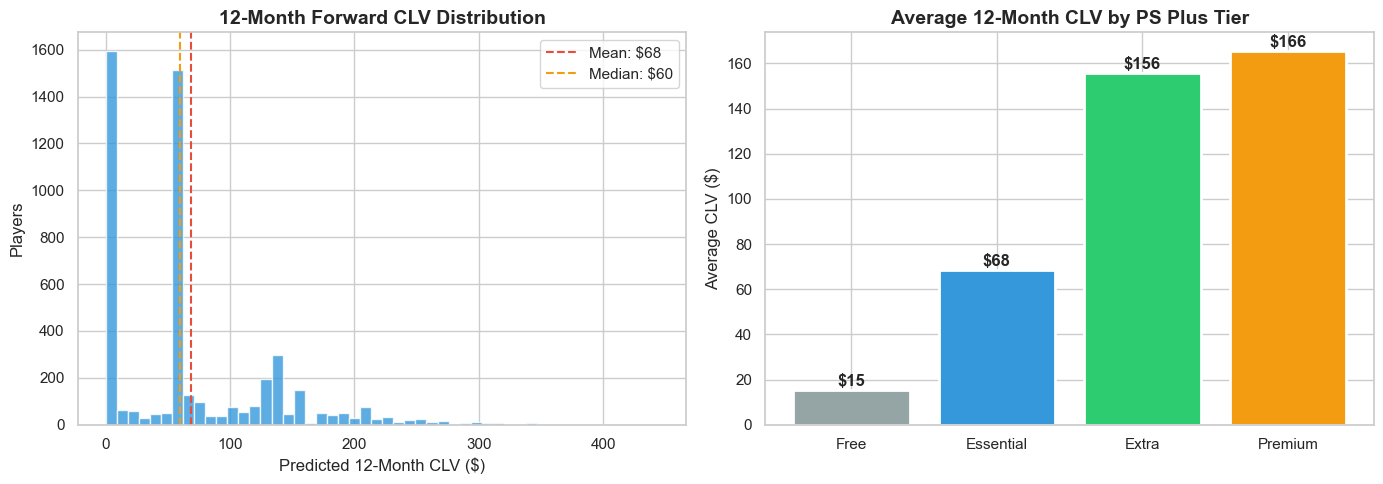

Top 10% of players by CLV account for 32% of total predicted revenue


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: CLV distribution
axes[0].hist(clv["clv_12m"], bins=50, color="#3498db", edgecolor="white", alpha=0.8)
axes[0].axvline(clv["clv_12m"].mean(), color="#e74c3c", linestyle="--",
               label=f'Mean: ${clv["clv_12m"].mean():.0f}')
axes[0].axvline(clv["clv_12m"].median(), color="#f39c12", linestyle="--",
               label=f'Median: ${clv["clv_12m"].median():.0f}')
axes[0].set_title("12-Month Forward CLV Distribution", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Predicted 12-Month CLV ($)")
axes[0].set_ylabel("Players")
axes[0].legend(fontsize=11)

# Right: CLV by tier
tier_order = ["Free", "Essential", "Extra", "Premium"]
tier_clv = clv.groupby("tier")["clv_12m"].mean().reindex(tier_order)
colors = ["#95a5a6", "#3498db", "#2ecc71", "#f39c12"]
bars = axes[1].bar(tier_order, tier_clv.values, color=colors, edgecolor="white", linewidth=2)
axes[1].set_title("Average 12-Month CLV by PS Plus Tier", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Average CLV ($)")
for bar, val in zip(bars, tier_clv.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f"${val:.0f}", ha="center", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

# CLV concentration
sorted_clv = clv["clv_12m"].sort_values(ascending=False)
top_10_value = sorted_clv.head(int(len(sorted_clv) * 0.1)).sum()
total_value = sorted_clv.sum()
print(f"Top 10% of players by CLV account for {top_10_value/total_value:.0%} of total predicted revenue")

### CLV Segments

We segment players into value tiers. These tiers determine the maximum retention
budget justifiable for each player — you don't spend $50 to retain a $10 customer.

In [11]:
clv["clv_segment"] = pd.cut(
    clv["clv_12m"],
    bins=[-0.01, 10, 50, 150, 500, float("inf")],
    labels=["Minimal (<$10)", "Low ($10-50)", "Medium ($50-150)", "High ($150-500)", "Platinum ($500+)"]
)

clv_seg_summary = clv.groupby("clv_segment", observed=True).agg(
    n_players=("player_id", "count"),
    avg_clv=("clv_12m", "mean"),
    total_clv=("clv_12m", "sum"),
).reset_index()
clv_seg_summary["pct_players"] = (clv_seg_summary["n_players"] / len(clv) * 100).round(1)
clv_seg_summary["pct_value"] = (clv_seg_summary["total_clv"] / clv["clv_12m"].sum() * 100).round(1)

print("CLV Segments:\n")
hdr = "  {:20s} {:>8s} {:>10s} {:>9s} {:>9s}".format("Segment", "Players", "% Players", "Avg CLV", "% Value")
print(hdr)
print("-" * 60)
for _, row in clv_seg_summary.iterrows():
    print(f"  {row['clv_segment']:<18s} {row['n_players']:>8,} {row['pct_players']:>9.1f}%"
          f"  ${row['avg_clv']:>7.0f}  {row['pct_value']:>8.1f}%")

print(f"\nThis concentration is typical — a small 'Platinum' segment drives outsized value.")

CLV Segments:

  Segment               Players  % Players   Avg CLV   % Value
------------------------------------------------------------
  Minimal (<$10)        1,628      32.6%  $      1       0.3%
  Low ($10-50)            196       3.9%  $     32       1.8%
  Medium ($50-150)      2,581      51.6%  $     82      61.7%
  High ($150-500)         595      11.9%  $    208      36.2%

This concentration is typical — a small 'Platinum' segment drives outsized value.


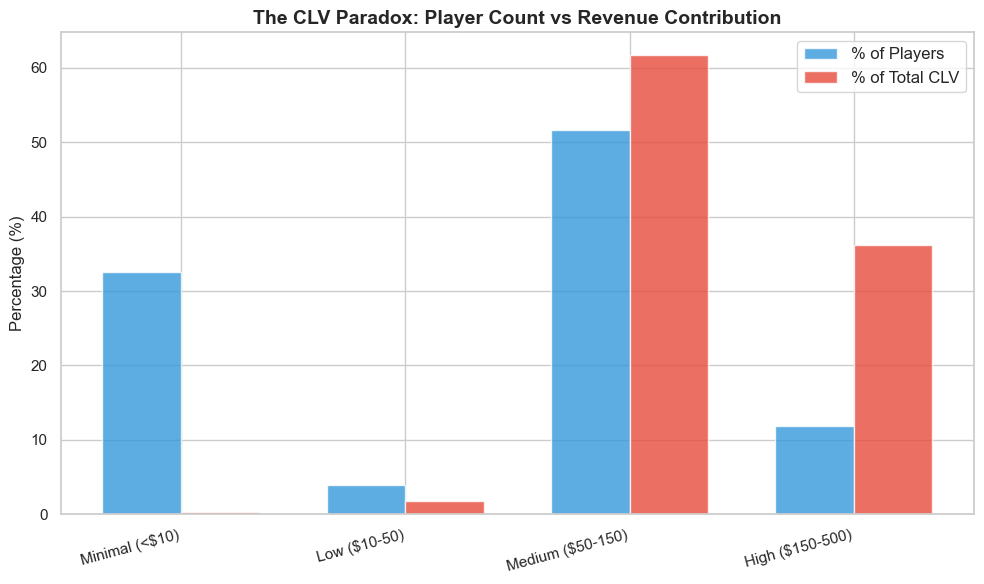

The gap between blue and red bars tells the story:
High-value segments are small in number but massive in revenue contribution.
This is exactly why personalised retention is worth the investment.


In [12]:
# Visualise: players vs value contribution
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(clv_seg_summary))
width = 0.35
bars1 = ax.bar([i - width/2 for i in x], clv_seg_summary["pct_players"],
               width, label="% of Players", color="#3498db", alpha=0.8)
bars2 = ax.bar([i + width/2 for i in x], clv_seg_summary["pct_value"],
               width, label="% of Total CLV", color="#e74c3c", alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(clv_seg_summary["clv_segment"], rotation=15, ha="right")
ax.set_ylabel("Percentage (%)")
ax.set_title("The CLV Paradox: Player Count vs Revenue Contribution",
             fontsize=14, fontweight="bold")
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

print("The gap between blue and red bars tells the story:")
print("High-value segments are small in number but massive in revenue contribution.")
print("This is exactly why personalised retention is worth the investment.")

---
# Part 2: Next Best Action Framework

### The Decision Matrix

NBA combines three model outputs into a single recommended action per player:

| Input | Source | Role |
|-------|--------|------|
| Churn probability | Notebook 03 | *Should we act?* — prioritises at-risk players |
| DLC propensity | Notebook 04 | *What should we offer?* — identifies purchase-ready players |
| CLV (12-month) | This notebook | *How much should we invest?* — calibrates intervention cost |

The framework assigns each player to one of **five action categories**,
each with a specific intervention strategy and budget ceiling tied to their CLV.

In [13]:
# ── Assemble the NBA table ──

nba = player360[["player_id"]].copy()

# Add scores
nba = nba.merge(churn_scores[["player_id", "churn_probability", "risk_tier"]],
                on="player_id", how="left")
nba = nba.merge(propensity_scores[["player_id", "dlc_propensity", "propensity_tier"]],
                on="player_id", how="left")
nba = nba.merge(clv[["player_id", "tier", "clv_12m", "clv_segment", "historical_spend"]],
                on="player_id", how="left")

# Fill missing churn scores (Free tier)
nba["churn_probability"] = nba["churn_probability"].fillna(0.0)
nba["risk_tier"] = nba["risk_tier"].fillna("N/A (Free)")

print(f"NBA table: {len(nba):,} players")
print(f"Columns: {list(nba.columns)}")
nba.head()

NBA table: 5,000 players
Columns: ['player_id', 'churn_probability', 'risk_tier', 'dlc_propensity', 'propensity_tier', 'tier', 'clv_12m', 'clv_segment', 'historical_spend']


,player_id,churn_probability,risk_tier,dlc_propensity,propensity_tier,tier,clv_12m,clv_segment,historical_spend
0,PSN-00000,0.000011,Low Risk,0.024543,Low,Essential,59.989356,Medium ($50-150),0.00
1,PSN-00001,0.000000,N/A (Free),0.090370,Low,Free,0.000000,Minimal (<$10),0.00
2,PSN-00002,0.926722,Critical,0.011263,Low,Essential,4.395946,Minimal (<$10),0.00
3,PSN-00003,0.999926,Critical,0.013173,Low,Essential,0.004417,Minimal (<$10),0.00
4,PSN-00004,0.000007,Low Risk,0.676151,Very High,Essential,279.928726,High ($150-500),114.96


### Action Assignment Logic

The decision rules reflect real marketing priorities:

1. **Retain Critical** — Churn probability > 0.6 AND CLV > $50. These are valuable players
   about to leave. Top priority: save the relationship with a meaningful retention offer.

2. **Retain Standard** — Churn probability > 0.35 AND CLV > $20. At risk but lower urgency.
   Lighter intervention: personalised content recommendation, re-engagement email.

3. **Upsell** — Churn probability < 0.35 AND DLC propensity > 0.40. Healthy and purchase-ready.
   Send them targeted DLC offers, new release recommendations, or tier upgrade prompts.

4. **Nurture** — Low churn risk, low propensity, but some engagement. No immediate action,
   but include in general engagement campaigns to build toward future purchases.

5. **Monitor** — Very low engagement or very low CLV. Don't invest — check back next quarter.

In [15]:
def assign_action(row):
    churn = row["churn_probability"]
    prop = row["dlc_propensity"]
    clv_val = row["clv_12m"]

    # Priority 1: Save high-value churners
    if churn > 0.6 and clv_val > 50:
        return "Retain Critical"

    # Priority 2: Intervene with at-risk players
    if churn > 0.35 and clv_val > 20:
        return "Retain Standard"

    # Priority 3: Grow healthy, purchase-ready players
    if churn <= 0.35 and prop > 0.40:
        return "Upsell"

    # Priority 4: Nurture engaged but not purchase-ready
    if churn <= 0.35 and clv_val > 20:
        return "Nurture"

    # Default: Monitor
    return "Monitor"

nba["action"] = nba.apply(assign_action, axis=1)

# Assign budget ceiling based on CLV (10% of 12-month CLV)
nba["max_intervention_budget"] = (nba["clv_12m"] * 0.10).round(2)

# Summary
action_order = ["Retain Critical", "Retain Standard", "Upsell", "Nurture", "Monitor"]
action_summary = nba.groupby("action").agg(
    n_players=("player_id", "count"),
    avg_clv=("clv_12m", "mean"),
    avg_churn=("churn_probability", "mean"),
    avg_propensity=("dlc_propensity", "mean"),
    total_clv_at_risk=("clv_12m", "sum"),
).reindex(action_order)

action_summary["pct_players"] = (action_summary["n_players"] / len(nba) * 100).round(1)

print("\nNEXT BEST ACTION SUMMARY\n")
hdr = "  {:20s} {:>8s} {:>7s} {:>9s} {:>10s} {:>9s} {:>12s}".format("Action", "Players", "% Base", "Avg CLV", "Avg Churn", "Avg Prop", "Total CLV")
print(hdr)
print("=" * 80)
for action in action_order:
    if action in action_summary.index:
        row = action_summary.loc[action]
        print(f"  {action:<18s} {row['n_players']:>8,.0f} {row['pct_players']:>6.1f}%"
              f"  ${row['avg_clv']:>7.0f}  {row['avg_churn']:>9.1%}  {row['avg_propensity']:>8.1%}"
              f"  ${row['total_clv_at_risk']:>10,.0f}")


NEXT BEST ACTION SUMMARY

  Action                Players  % Base   Avg CLV  Avg Churn  Avg Prop    Total CLV
  Retain Critical           7    0.1%  $     70      94.5%     13.8%  $       487
  Retain Standard          53    1.1%  $     33      70.5%     12.0%  $     1,738
  Upsell                1,506   30.1%  $    118       0.0%     74.2%  $   177,959
  Nurture               1,889   37.8%  $     85       0.5%     14.5%  $   160,144
  Monitor               1,545   30.9%  $      1      36.0%      9.8%  $     1,581


### Visualising the NBA Framework

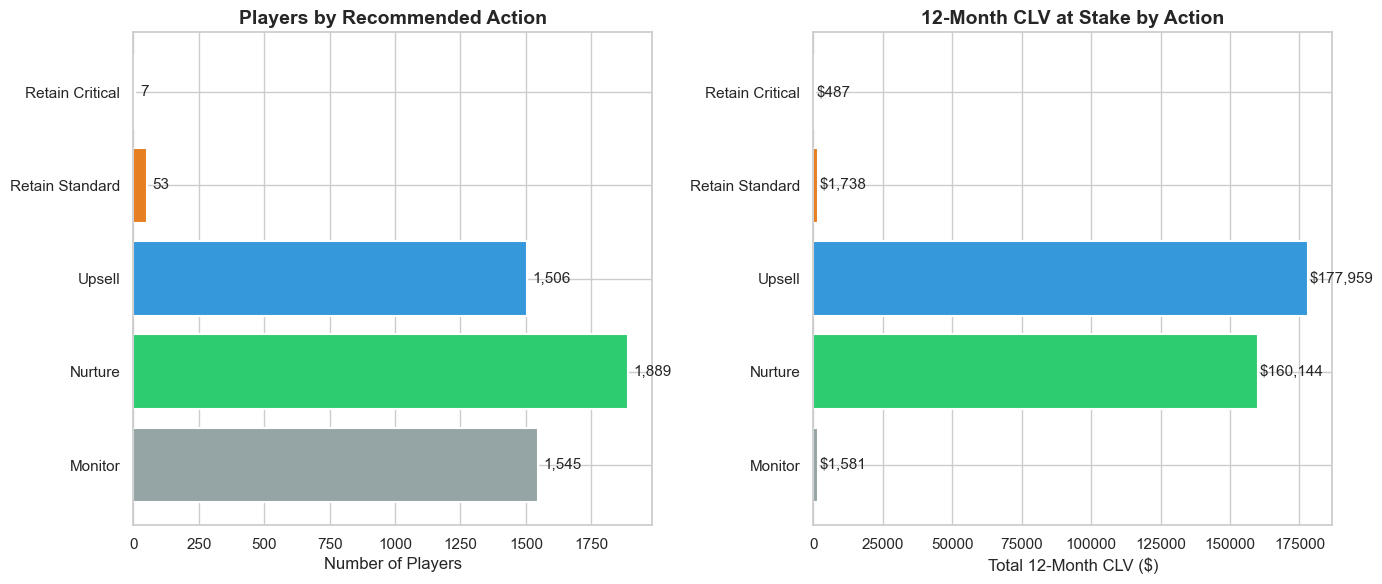

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Action distribution
action_colors = {
    "Retain Critical": "#e74c3c",
    "Retain Standard": "#e67e22",
    "Upsell": "#3498db",
    "Nurture": "#2ecc71",
    "Monitor": "#95a5a6",
}

action_counts = nba["action"].value_counts().reindex(action_order)
available_actions = [a for a in action_order if a in action_counts.index and action_counts[a] > 0]
bars = axes[0].barh(
    available_actions[::-1],
    [action_counts[a] for a in available_actions[::-1]],
    color=[action_colors[a] for a in available_actions[::-1]],
    edgecolor="white", linewidth=1.5
)
axes[0].set_title("Players by Recommended Action", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Number of Players")
for bar in bars:
    axes[0].text(bar.get_width() + 20, bar.get_y() + bar.get_height()/2,
                f"{bar.get_width():,.0f}", va="center", fontsize=11)

# Right: CLV at stake by action
action_clv = nba.groupby("action")["clv_12m"].sum().reindex(action_order)
available_actions_clv = [a for a in action_order if a in action_clv.index and action_clv[a] > 0]
bars2 = axes[1].barh(
    available_actions_clv[::-1],
    [action_clv[a] for a in available_actions_clv[::-1]],
    color=[action_colors[a] for a in available_actions_clv[::-1]],
    edgecolor="white", linewidth=1.5
)
axes[1].set_title("12-Month CLV at Stake by Action", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Total 12-Month CLV ($)")
for bar in bars2:
    axes[1].text(bar.get_width() + 500, bar.get_y() + bar.get_height()/2,
                f"${bar.get_width():,.0f}", va="center", fontsize=11)

plt.tight_layout()
plt.show()

### The Player Action Map

The signature visualisation: every player plotted by churn risk vs purchase propensity,
sized by CLV, coloured by recommended action.

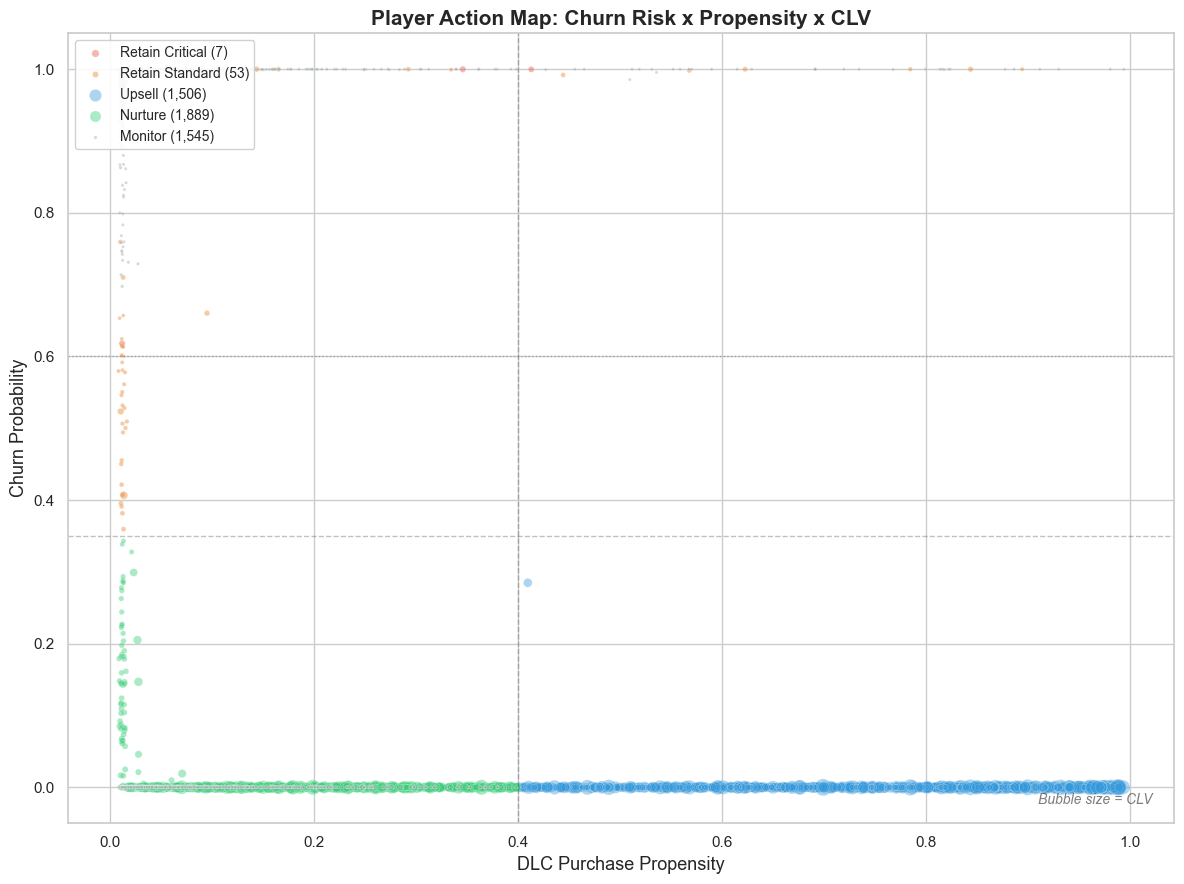

In [17]:
fig, ax = plt.subplots(figsize=(12, 9))

# Size by CLV (normalise to visible range)
sizes = np.clip(nba["clv_12m"] / nba["clv_12m"].max() * 150, 5, 150)

for action in action_order:
    subset = nba[nba["action"] == action]
    if len(subset) == 0:
        continue
    subset_sizes = sizes[subset.index]
    ax.scatter(
        subset["dlc_propensity"], subset["churn_probability"],
        s=subset_sizes, alpha=0.4, c=action_colors[action],
        label=f"{action} ({len(subset):,})", edgecolors="white", linewidth=0.3
    )

# Threshold lines
ax.axhline(y=0.35, color="#333", linestyle="--", alpha=0.3, linewidth=1)
ax.axhline(y=0.60, color="#333", linestyle=":", alpha=0.3, linewidth=1)
ax.axvline(x=0.40, color="#333", linestyle="--", alpha=0.3, linewidth=1)

ax.set_title("Player Action Map: Churn Risk x Propensity x CLV",
             fontsize=15, fontweight="bold")
ax.set_xlabel("DLC Purchase Propensity", fontsize=13)
ax.set_ylabel("Churn Probability", fontsize=13)
ax.legend(fontsize=10, loc="upper left", framealpha=0.9)

# Annotation
ax.text(0.98, 0.02, "Bubble size = CLV", transform=ax.transAxes,
        fontsize=10, ha="right", va="bottom", style="italic", alpha=0.6)

plt.tight_layout()
plt.show()

---
# Part 3: Business Impact Simulation

### What If PlayStation Deployed This Framework?

To estimate impact, we make conservative assumptions about intervention effectiveness:

| Action | Intervention | Assumed Success Rate | Cost per Player |
|--------|-------------|---------------------|----------------|
| Retain Critical | Personal offer (free month, discount) | 30% save rate | $15 |
| Retain Standard | Re-engagement campaign (email, content push) | 15% save rate | $3 |
| Upsell | Targeted DLC/upgrade recommendation | 10% conversion lift | $2 |
| Nurture | General engagement content | 3% future conversion | $0.50 |
| Monitor | No action | — | $0 |

These are illustrative. Real values would come from A/B test results.

In [19]:
# Impact assumptions
IMPACT = {
    "Retain Critical": {"success_rate": 0.30, "cost_per_player": 15.0},
    "Retain Standard": {"success_rate": 0.15, "cost_per_player": 3.0},
    "Upsell":          {"success_rate": 0.10, "cost_per_player": 2.0},
    "Nurture":         {"success_rate": 0.03, "cost_per_player": 0.50},
    "Monitor":         {"success_rate": 0.00, "cost_per_player": 0.0},
}

impact_rows = []
for action in action_order:
    subset = nba[nba["action"] == action]
    if len(subset) == 0:
        continue

    n = len(subset)
    params = IMPACT[action]
    avg_clv = subset["clv_12m"].mean()

    if "Retain" in action:
        # Revenue saved = players saved * their average CLV
        players_saved = n * params["success_rate"]
        revenue_impact = players_saved * avg_clv
    elif action == "Upsell":
        # Revenue gained = additional conversion * average DLC spend
        avg_dlc_spend = 25  # approximate average DLC price
        additional_conversions = n * params["success_rate"]
        revenue_impact = additional_conversions * avg_dlc_spend
    elif action == "Nurture":
        additional_conversions = n * params["success_rate"]
        revenue_impact = additional_conversions * 15  # lower value conversions
    else:
        revenue_impact = 0

    total_cost = n * params["cost_per_player"]
    net_impact = revenue_impact - total_cost

    impact_rows.append({
        "action": action,
        "players": n,
        "gross_revenue_impact": revenue_impact,
        "campaign_cost": total_cost,
        "net_impact": net_impact,
        "roi": net_impact / max(total_cost, 1),
    })

impact_df = pd.DataFrame(impact_rows)

print("ESTIMATED BUSINESS IMPACT\n")
hdr = "  {:20s} {:>8s} {:>11s} {:>9s} {:>12s} {:>7s}".format("Action", "Players", "Gross Rev", "Cost", "Net Impact", "ROI")
print(hdr)
print("=" * 70)
for _, row in impact_df.iterrows():
    print(f"  {row['action']:<18s} {row['players']:>8,}"
          f"  ${row['gross_revenue_impact']:>9,.0f}  ${row['campaign_cost']:>7,.0f}"
          f"  ${row['net_impact']:>10,.0f}  {row['roi']:>6.1f}x")
print("-" * 70)
total_net = impact_df["net_impact"].sum()
total_cost = impact_df["campaign_cost"].sum()
print(f"  {'TOTAL':<18s} {len(nba):>8,}"
      f"  ${impact_df['gross_revenue_impact'].sum():>9,.0f}  ${total_cost:>7,.0f}"
      f"  ${total_net:>10,.0f}  {total_net/max(total_cost,1):>6.1f}x")


ESTIMATED BUSINESS IMPACT

  Action                Players   Gross Rev      Cost   Net Impact     ROI
  Retain Critical           7  $      146  $    105  $        41     0.4x
  Retain Standard          53  $      261  $    159  $       102     0.6x
  Upsell                1,506  $    3,765  $  3,012  $       753     0.2x
  Nurture               1,889  $      850  $    944  $       -94    -0.1x
  Monitor               1,545  $        0  $      0  $         0     0.0x
----------------------------------------------------------------------
  TOTAL                 5,000  $    5,022  $  4,220  $       801     0.2x


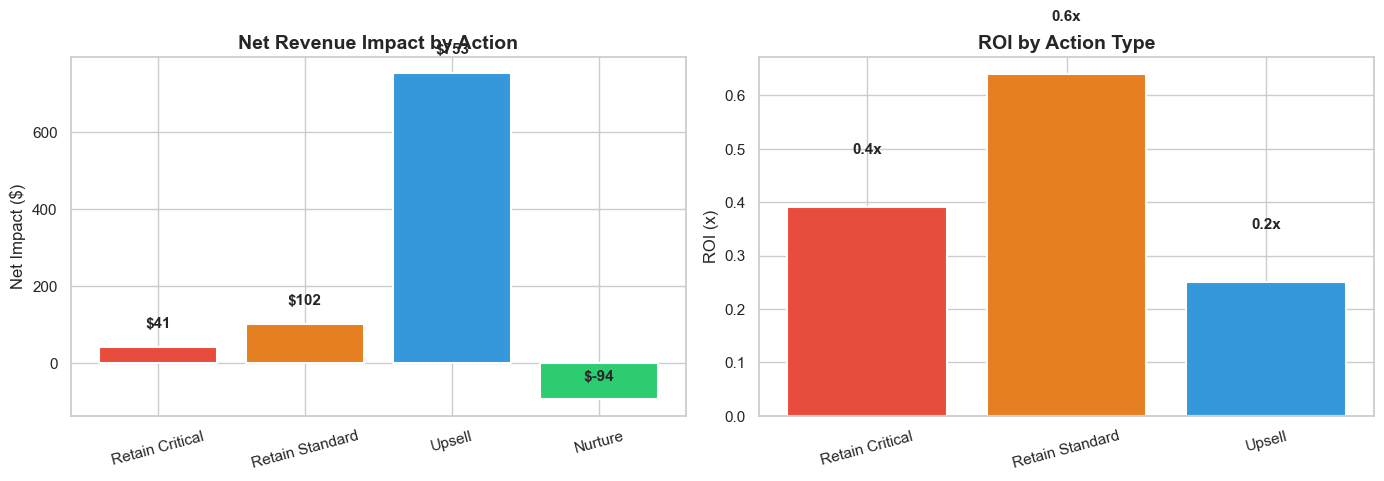

In [20]:
# Visualise impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Net impact by action
impact_plot = impact_df[impact_df["net_impact"] != 0].copy()
if len(impact_plot) > 0:
    bars = axes[0].bar(
        impact_plot["action"], impact_plot["net_impact"],
        color=[action_colors.get(a, "#333") for a in impact_plot["action"]],
        edgecolor="white", linewidth=1.5
    )
    axes[0].set_title("Net Revenue Impact by Action", fontsize=14, fontweight="bold")
    axes[0].set_ylabel("Net Impact ($)")
    axes[0].tick_params(axis="x", rotation=15)
    for bar in bars:
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                    f"${bar.get_height():,.0f}", ha="center", fontsize=11, fontweight="bold")

# Right: ROI by action
roi_plot = impact_df[(impact_df["roi"] > 0) & (impact_df["campaign_cost"] > 0)].copy()
if len(roi_plot) > 0:
    bars2 = axes[1].bar(
        roi_plot["action"], roi_plot["roi"],
        color=[action_colors.get(a, "#333") for a in roi_plot["action"]],
        edgecolor="white", linewidth=1.5
    )
    axes[1].set_title("ROI by Action Type", fontsize=14, fontweight="bold")
    axes[1].set_ylabel("ROI (x)")
    axes[1].tick_params(axis="x", rotation=15)
    for bar in bars2:
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f"{bar.get_height():.1f}x", ha="center", fontsize=11, fontweight="bold")

plt.tight_layout()
plt.show()

---
## Player Profiles: Bringing the Framework to Life

The NBA framework is abstract until you see it applied to individual players.
Let's pull example profiles from each action category to show what the recommendations
look like in practice.

In [21]:
# Add archetype for context
nba_profiles = nba.merge(archetype_key, on="player_id", how="left")

# Sample one player from each action
print("=" * 85)
print("PLAYER PROFILES — Example from Each Action Category")
print("=" * 85)

for action in action_order:
    subset = nba_profiles[nba_profiles["action"] == action]
    if len(subset) == 0:
        continue

    # Pick a representative player (closest to median CLV in the group)
    median_clv = subset["clv_12m"].median()
    player = subset.iloc[(subset["clv_12m"] - median_clv).abs().argsort()[:1]].iloc[0]

    print(f"\n--- {action.upper()} ---")
    print(f"  Player:     {player['player_id']}")
    print(f"  Archetype:  {player['archetype']} (hidden — for validation only)")
    print(f"  PS Plus:    {player['tier']}")
    print(f"  Churn Risk: {player['churn_probability']:.1%} ({player['risk_tier']})")
    print(f"  DLC Prop:   {player['dlc_propensity']:.1%} ({player['propensity_tier']})")
    print(f"  12M CLV:    ${player['clv_12m']:.2f}")
    print(f"  Max Budget: ${player['max_intervention_budget']:.2f}")

    # Recommended action narrative
    if action == "Retain Critical":
        print(f"  >> ACTION: Personal retention offer — this ${player['clv_12m']:.0f} player")
        print(f"     is {player['churn_probability']:.0%} likely to leave. Offer a free month")
        print(f"     or targeted discount. Budget up to ${player['max_intervention_budget']:.0f}.")
    elif action == "Retain Standard":
        print(f"  >> ACTION: Re-engagement campaign — send personalised content")
        print(f"     recommendations based on play history. Lightweight, scalable.")
    elif action == "Upsell":
        print(f"  >> ACTION: DLC recommendation — this player has {player['dlc_propensity']:.0%}")
        print(f"     purchase likelihood. Target with relevant DLC offers.")
    elif action == "Nurture":
        print(f"  >> ACTION: Include in general engagement campaigns.")
        print(f"     Build engagement to move toward future purchase readiness.")
    else:
        print(f"  >> ACTION: No active intervention. Monitor and re-score next quarter.")

print(f"\n{'=' * 85}")

PLAYER PROFILES — Example from Each Action Category

--- RETAIN CRITICAL ---
  Player:     PSN-00320
  Archetype:  dormant (hidden — for validation only)
  PS Plus:    Premium
  Churn Risk: 61.8% (Critical)
  DLC Prop:   1.2% (Low)
  12M CLV:    $61.13
  Max Budget: $6.11
  >> ACTION: Personal retention offer — this $61 player
     is 62% likely to leave. Offer a free month
     or targeted discount. Budget up to $6.

--- RETAIN STANDARD ---
  Player:     PSN-00342
  Archetype:  lapsed (hidden — for validation only)
  PS Plus:    Essential
  Churn Risk: 99.9% (Critical)
  DLC Prop:   4.5% (Low)
  12M CLV:    $30.05
  Max Budget: $3.00
  >> ACTION: Re-engagement campaign — send personalised content
     recommendations based on play history. Lightweight, scalable.

--- UPSELL ---
  Player:     PSN-02616
  Archetype:  core_gamer (hidden — for validation only)
  PS Plus:    Free
  Churn Risk: 0.0% (N/A (Free))
  DLC Prop:   85.2% (Very High)
  12M CLV:    $119.98
  Max Budget: $12.00
  >>

---
## Save Final Outputs

In [22]:
# Save the complete NBA table
nba_output = nba[[
    "player_id", "tier", "churn_probability", "risk_tier",
    "dlc_propensity", "propensity_tier", "clv_12m", "clv_segment",
    "action", "max_intervention_budget"
]].copy()

nba_output.to_csv(DATA_DIR / "nba_final.csv", index=False)
print(f"Saved: {DATA_DIR / 'nba_final.csv'}")
print(f"  {len(nba_output):,} players with action recommendations")

# Save CLV table
clv_output = clv[[
    "player_id", "tier", "historical_spend", "sub_clv_12m",
    "purchase_clv_12m", "clv_12m", "total_clv", "clv_segment"
]].copy()
clv_output.to_csv(DATA_DIR / "clv_estimates.csv", index=False)
print(f"Saved: {DATA_DIR / 'clv_estimates.csv'}")

# Summary stats for the report
print(f"\n{'=' * 60}")
print(f"PROJECT OUTPUT SUMMARY")
print(f"{'=' * 60}")
print(f"\nPlayers scored:     {len(nba_output):,}")
print(f"With churn risk:    {nba_output['churn_probability'].gt(0).sum():,} (paid subs)")
print(f"With DLC propensity: {len(nba_output):,} (all players)")
print(f"With CLV estimate:  {len(nba_output):,} (all players)")
print(f"\nAction distribution:")
for action in action_order:
    count = (nba_output["action"] == action).sum()
    pct = count / len(nba_output) * 100
    print(f"  {action:<20s}: {count:>5,} ({pct:.1f}%)")
print(f"\nTotal 12-month CLV:  ${nba_output['clv_12m'].sum():>12,.0f}")
print(f"Avg CLV per player:  ${nba_output['clv_12m'].mean():>12,.2f}")

Saved: data/nba_final.csv
  5,000 players with action recommendations
Saved: data/clv_estimates.csv

PROJECT OUTPUT SUMMARY

Players scored:     5,000
With churn risk:    3,643 (paid subs)
With DLC propensity: 5,000 (all players)
With CLV estimate:  5,000 (all players)

Action distribution:
  Retain Critical     :     7 (0.1%)
  Retain Standard     :    53 (1.1%)
  Upsell              : 1,506 (30.1%)
  Nurture             : 1,889 (37.8%)
  Monitor             : 1,545 (30.9%)

Total 12-month CLV:  $     341,910
Avg CLV per player:  $       68.38


---
## Summary: The Complete Pipeline

We've built an end-to-end data science pipeline that takes raw player behaviour and produces
**specific, actionable, economically justified recommendations** for each player:

```
Raw Events (sessions, purchases, trophies)
    |
    v
Player 360 Feature Table (47 features per player)
    |
    +---> Churn Model (who's leaving?)
    |         |
    +---> Propensity Model (who's buying?)
    |         |
    +---> CLV Estimation (what are they worth?)
              |
              v
    Next Best Action Framework
    (what should we do about each player?)
              |
              v
    Player-Level Recommendations
    + Budget Ceilings
    + Impact Estimates
```

### Key Takeaways for PlayStation's DSAE Team

1. **Churn is predictable and gradual** — engagement decays months before cancellation,
   giving a window for intervention. Auto-renew status, session trends, and recency are
   the strongest signals.

2. **Free DLC drives paid DLC** — the Valhalla signal (149% lift) confirms that free content
   engagement is a valuable purchase intent indicator. In a global model, broad engagement
   depth outranks this single signal, but for game-specific personalisation, it's directly actionable.

3. **CLV concentration demands personalisation** — a small fraction of players drives the
   majority of revenue. Treating all players the same leaves money on the table.

4. **The NBA framework turns scores into strategy** — five distinct action categories,
   each with specific interventions and budget ceilings tied to player value.
   This is the bridge between data science output and business ROI.

### What Would Change With Real Data

- **Model performance**: Our simulated data produces cleaner signals than real-world data.
  Expect AUC in the 0.78-0.85 range for churn, 0.70-0.80 for propensity with production data.
- **Feature engineering**: Real data would include social graph features, marketing response
  history, customer service interactions, and content browsing behaviour.
- **CLV model**: A probabilistic approach (BG/NBD + Gamma-Gamma or survival models) would
  replace our heuristic CLV estimation.
- **Experimentation**: Every assumption in the impact simulation would be validated through
  A/B testing before scaling.
- **Advanced modelling**: With sequential event data, LSTM or Transformer-based models could
  capture complex temporal patterns. Learned player embeddings from session sequences could
  power both predictions and content recommendations simultaneously.

